<a href="https://colab.research.google.com/github/VishalPokharel/Finetuned-LLM/blob/main/Finetuning_TinyLlama_on_crypto_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Link to the dataset on Kaggle:** [https://www.kaggle.com/datasets/oliviervha/crypto-news/]

I use the Tiny Llama model1 which has 1.1B parameters and LoRA to reduce the number of parameters we use for training.Full finetuning involves optimizing or training all layers of the neural network. While this approach typically yields the best results, it is also the most resource-intensive and time-consuming.Thus,I used  Low Rank Adaptation (LoRA).



**Base Model:** [TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T]

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.2.0 --progress-bar off
!pip install -qqq transformers==4.37.2 --progress-bar off
!pip install -qqq datasets==2.16.1 --progress-bar off
!pip install -qqq accelerate==0.27.0 --progress-bar off
!pip install -qqq bitsandbytes==0.42.0 --progress-bar off
!pip install -qqq peft==0.8.2 --progress-bar off
!pip install -qqq trl==0.7.10 --progress-bar off
!pip install -qqq flash-attn==2.5.2 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.1+cu121 requires torch==2.3.1, but you have torch 2.2.0 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.0 which is incompatible.
torchvision 0.18.1+cu121 requires torch==2.3.1, but you have torch 2.2.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2023.10.0 which is incompatible.
torchaudio 2.3.1+cu121 requires torch==2.3.1, but you have torch 2.2.0 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.0 which is incompatible.
torchvision 0.18.1+cu121 requires torch==2.3.1, but you have torch 2.2.0 which is incompatible.

In [ ]:
import inspect
import random
import sqlite3

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from pylab import rcParams
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from trl import DataCollatorForCompletionOnlyLM, SFTTrainer
from trl import DataCollatorForCompletionOnlyLM
%matplotlib inline
%config InlineBackend.figure_format='retina'

COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}

mpl.rcParams.update(MY_STYLE)
SEED = 42


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(SEED)

In [ ]:
!gdown 1rlX7CjTBeFLz2lvjaM1RbFGOX9beALQz

Downloading...
From: https://drive.google.com/uc?id=1rlX7CjTBeFLz2lvjaM1RbFGOX9beALQz
To: /content/crypto-news-db.zip
100% 4.85M/4.85M [00:00<00:00, 10.5MB/s]


In [ ]:
!unzip crypto-news-db.zip

Archive:  crypto-news-db.zip
  inflating: crypto-news.db          


**Preparing dataset:**


*   Cryptocurrency news dataset
*   Took care of how much tokens are needed in input and output and model's maximum context width and choose whether or not able to fit within the context window *(This consideration is necessary to determine whether the entire input and output can fit within the model's context window without exceeding its capacity.)*
*   Split dataset into training, test and validation
*   Used template to prepare own data from loaded kaggle data




In [ ]:
connection = sqlite3.connect("crypto-news.db")
train_df = pd.read_sql_query("SELECT * FROM train", connection)
val_df = pd.read_sql_query("SELECT * FROM validation", connection)
test_df = pd.read_sql_query("SELECT * FROM test", connection)

train_df.shape, val_df.shape, test_df.shape

((24829, 9), (4966, 9), (1242, 9))

In [ ]:
train_df.head()

,date,source,subject,text,title,url,sentiment,polarity,subjectivity
0,2022-04-12 12:02:00,CryptoPotato,ethereum,IDEG's new investment vehicle is part of its t...,IDEG Appoints Coinbase Prime as Strategic Part...,https://cryptopotato.com/ideg-appoints-coinbas...,positive,0.05,0.18
1,2022-10-26 18:00:00,CryptoNews,altcoin,"IBAT, the project's token of Battle infinity, ...",Battle Infinity Token Trending on CoinGecko - ...,https://cryptonews.com/news/battle-infinity-to...,positive,0.55,0.70
2,2023-02-08 16:00:00,CryptoNews,altcoin,"Get your daily, bite-sized digest of cryptoass...",Today in Crypto: Brave Reveals Solana Dapp Sup...,https://cryptonews.com/news/today-crypto-brave...,neutral,0.00,0.00
3,2022-03-05 19:20:00,CryptoPotato,blockchain,A BlockFi study found out that US women have s...,33% of Surveyed American Women Intend to Buy C...,https://cryptopotato.com/33-of-surveyed-americ...,neutral,0.00,0.00
4,2022-04-20 19:16:24,CoinTelegraph,blockchain,The symbol was quickly 'erased' via a communit...,Shiba Inu blacklists user for drawing hate sym...,https://cointelegraph.com/news/shiba-inu-black...,positive,0.33,0.50


In [ ]:
def create_grid(n_rows, n_columns):
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_columns, figsize=(n_columns * 5, n_rows * 4)
    )
    return fig, axes.flatten()

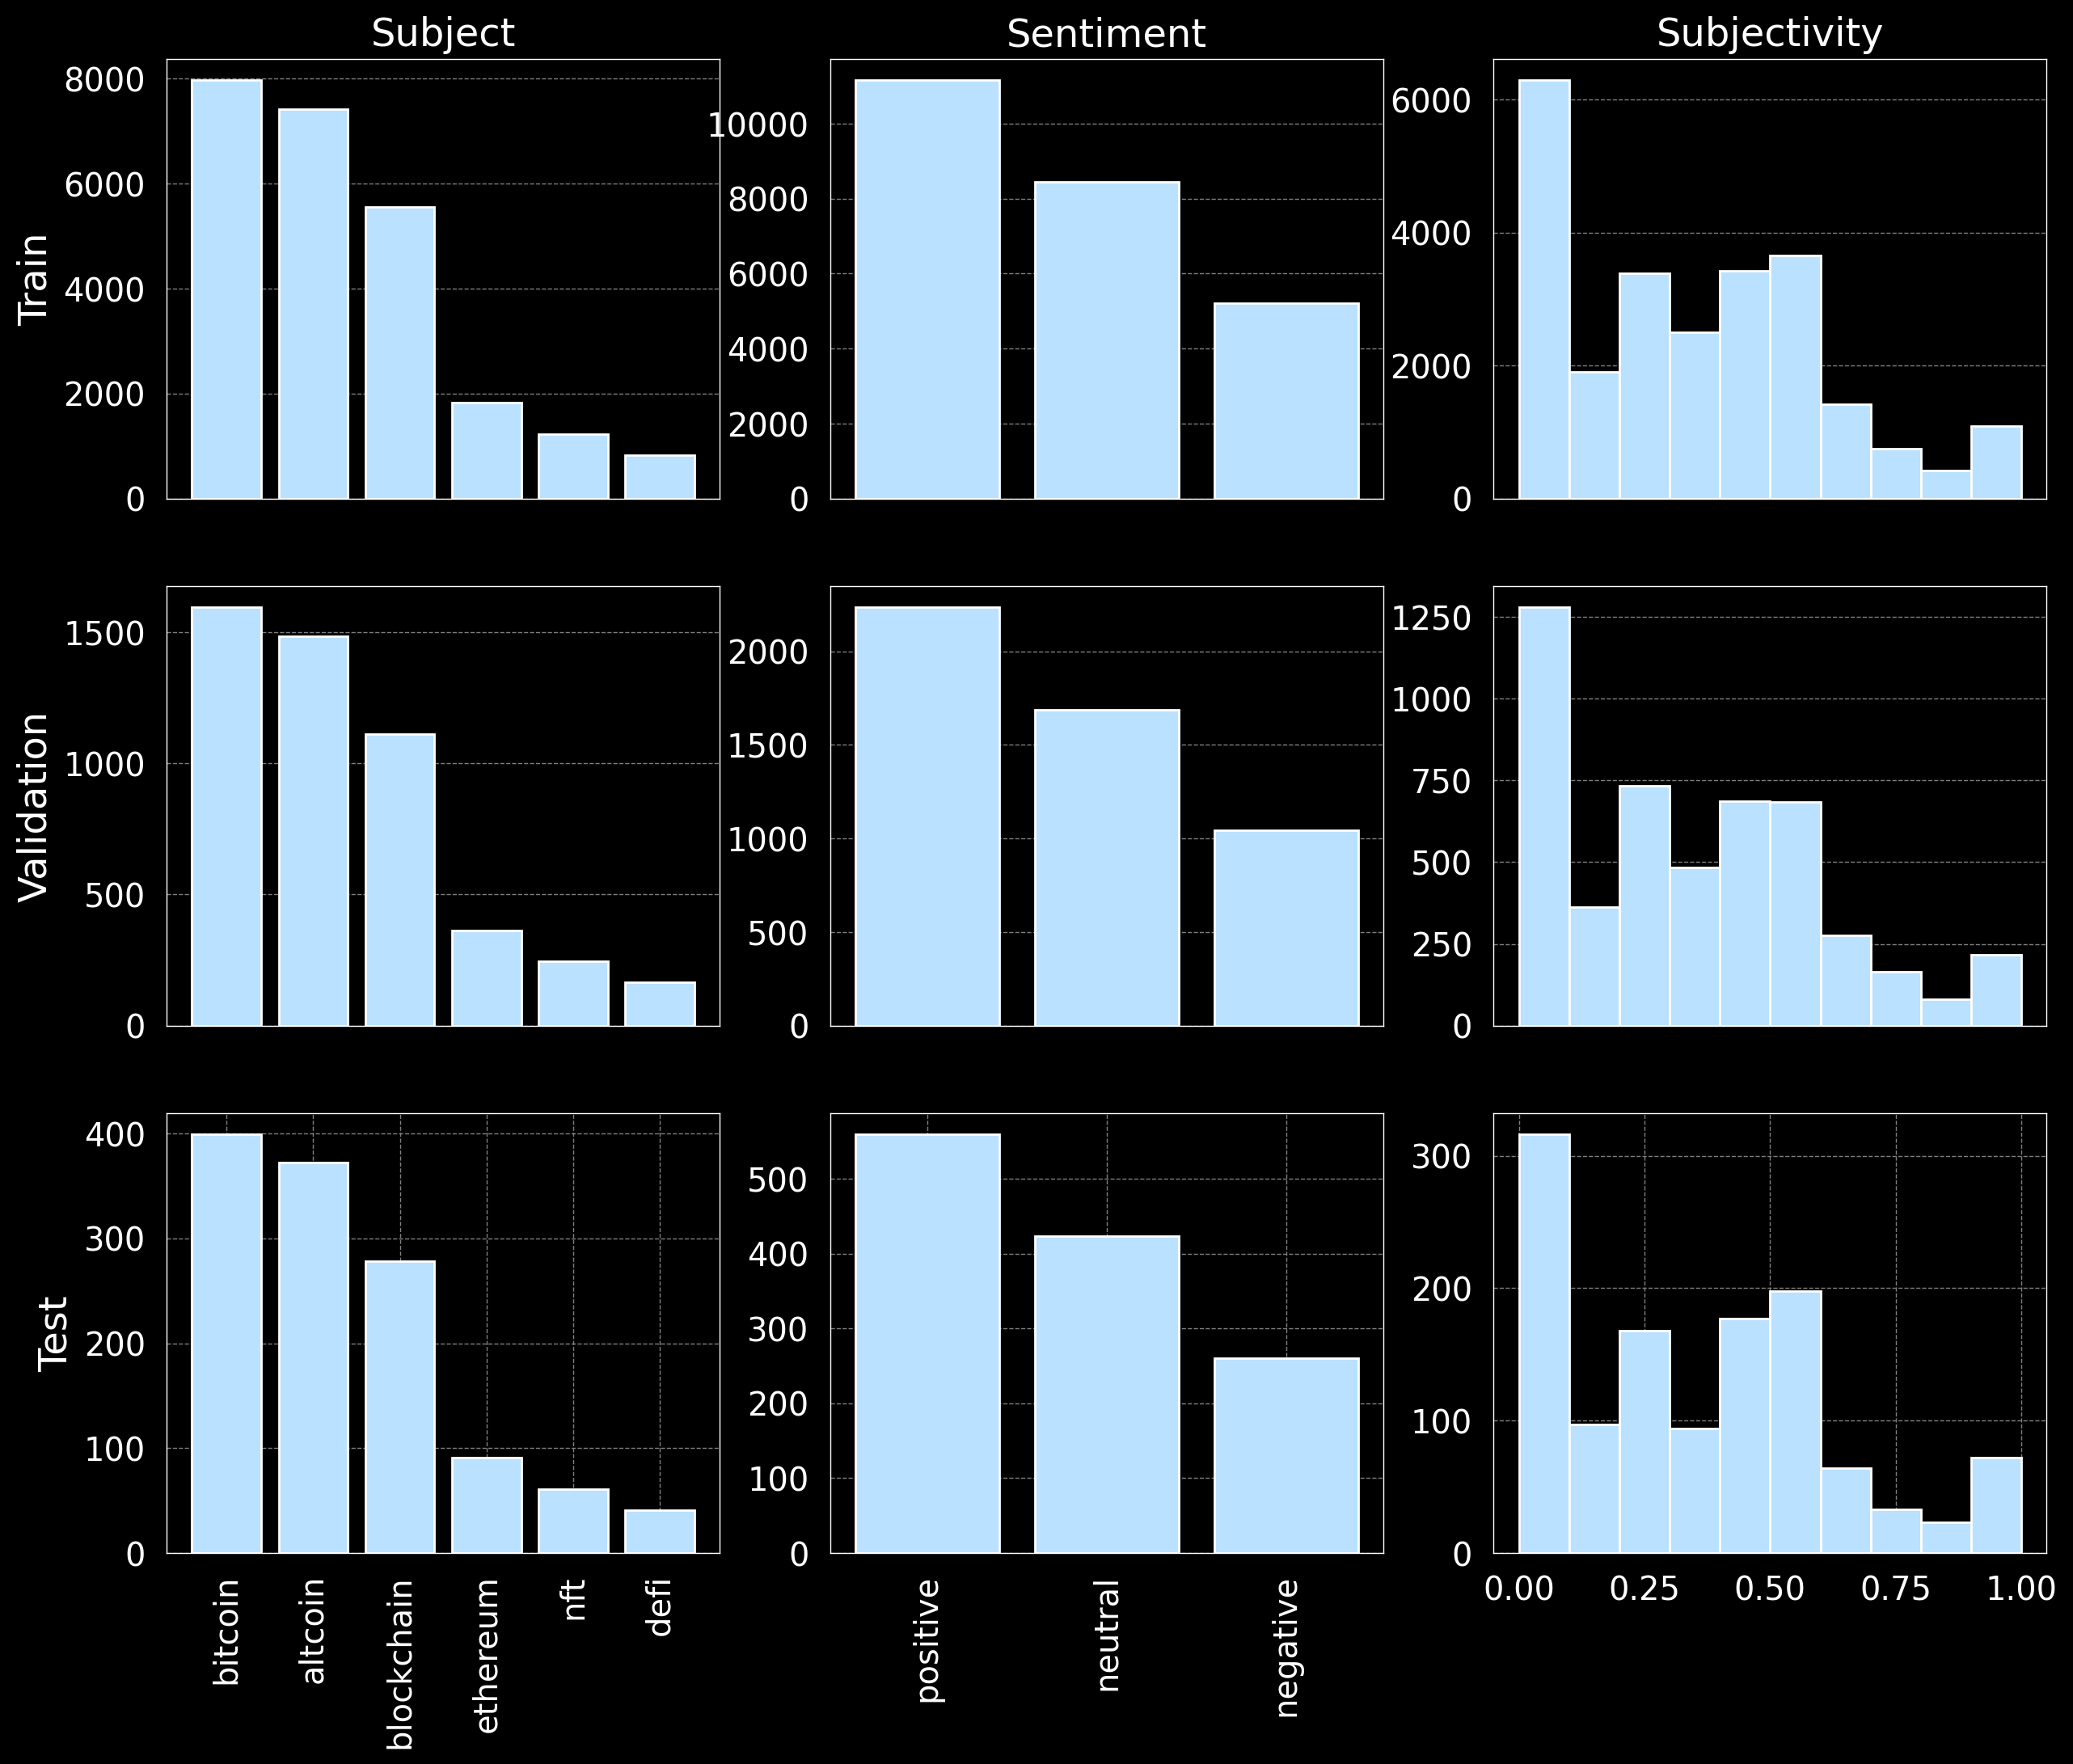

In [ ]:
fig, axes = create_grid(n_rows=3, n_columns=3)

subjects = [
    train_df.subject.value_counts(),
    val_df.subject.value_counts(),
    test_df.subject.value_counts(),
]
sentiments = [
    train_df.sentiment.value_counts(),
    val_df.sentiment.value_counts(),
    test_df.sentiment.value_counts(),
]
subjectivities = [train_df.subjectivity, val_df.subjectivity, test_df.subjectivity]

axes[0].bar(subjects[0].index, subjects[0].values)
axes[0].set_title("Subject")
axes[0].set_ylabel("Train")
axes[0].set_xticklabels([])
axes[0].set_xticks([])

axes[3].bar(subjects[1].index, subjects[1].values)
axes[3].set_ylabel("Validation")
axes[3].set_xticklabels([])
axes[3].set_xticks([])

axes[6].bar(subjects[2].index, subjects[2].values)
axes[6].set_ylabel("Test")
axes[6].set_xticks(axes[6].get_xticks())
axes[6].set_xticklabels(subjects[2].index, rotation=90)

axes[1].bar(sentiments[0].index, sentiments[0].values)
axes[1].set_title("Sentiment")
axes[1].set_xticklabels([])
axes[1].set_xticks([])

axes[4].bar(sentiments[1].index, sentiments[1].values)
axes[4].set_xticklabels([])
axes[4].set_xticks([])

axes[7].bar(sentiments[2].index, sentiments[2].values)
axes[7].set_xticks(axes[7].get_xticks())
axes[7].set_xticklabels(sentiments[2].index, rotation=90)

axes[2].hist(subjectivities[0])
axes[2].set_title("Subjectivity")
axes[2].set_xticklabels([])
axes[2].set_xticks([])

axes[5].hist(subjectivities[1])
axes[5].set_xticklabels([])
axes[5].set_xticks([])

axes[8].hist(subjectivities[2])

plt.show();

# **Analysis**
We have a very large bias towards Bitcoin outcome and blockchain examples which is again something that not desired in the data set.
I can use some techniques such as oversampling, undersampling  in order to fight this but just for this demonstration, I stick back to the given distribution.

In [ ]:
dataset = {
    "train": Dataset.from_pandas(train_df),
    "val": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df),
}
dataset

{'train': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 24829
 }),
 'val': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 4966
 }),
 'test': Dataset({
     features: ['date', 'source', 'subject', 'text', 'title', 'url', 'sentiment', 'polarity', 'subjectivity'],
     num_rows: 1242
 })}

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"
PAD_TOKEN = "<pad>"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_eos_token=True, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"
# if you are training with more than one training example per batch, usually the embeedings or tokenizer is getting scrumbled,
# and at least the words and the responses don''t get very good and models try to speak a lot and repeat the sentences and if
# you set the pad token, model stops generating repeated sentences.
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2" if available
)
model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

Embedding(32008, 2048)

In [ ]:
tokenizer.bos_token, tokenizer.bos_token_id

('<s>', 1)

In [ ]:
PAD_TOKEN in tokenizer.get_vocab()

True

In [ ]:
def format_example(example):
    return inspect.cleandoc(
        f"""
### Title:
{example["title"]}
### Text:
{example["text"]}
### Prediction:
subject: {example["subject"]}
sentiment: {example["sentiment"]}
"""
    )

In [ ]:
print(format_example(dataset["train"][0]))

### Title:
IDEG Appoints Coinbase Prime as Strategic Partner to Launch Ethereum Enhanced Portfolio
### Text:
IDEG's new investment vehicle is part of its thematic product suite - TIMES and it comes following a partnership with Coinbase.
### Prediction:
subject: ethereum
sentiment: positive


100%|██████████| 24829/24829 [00:11<00:00, 2167.99it/s]


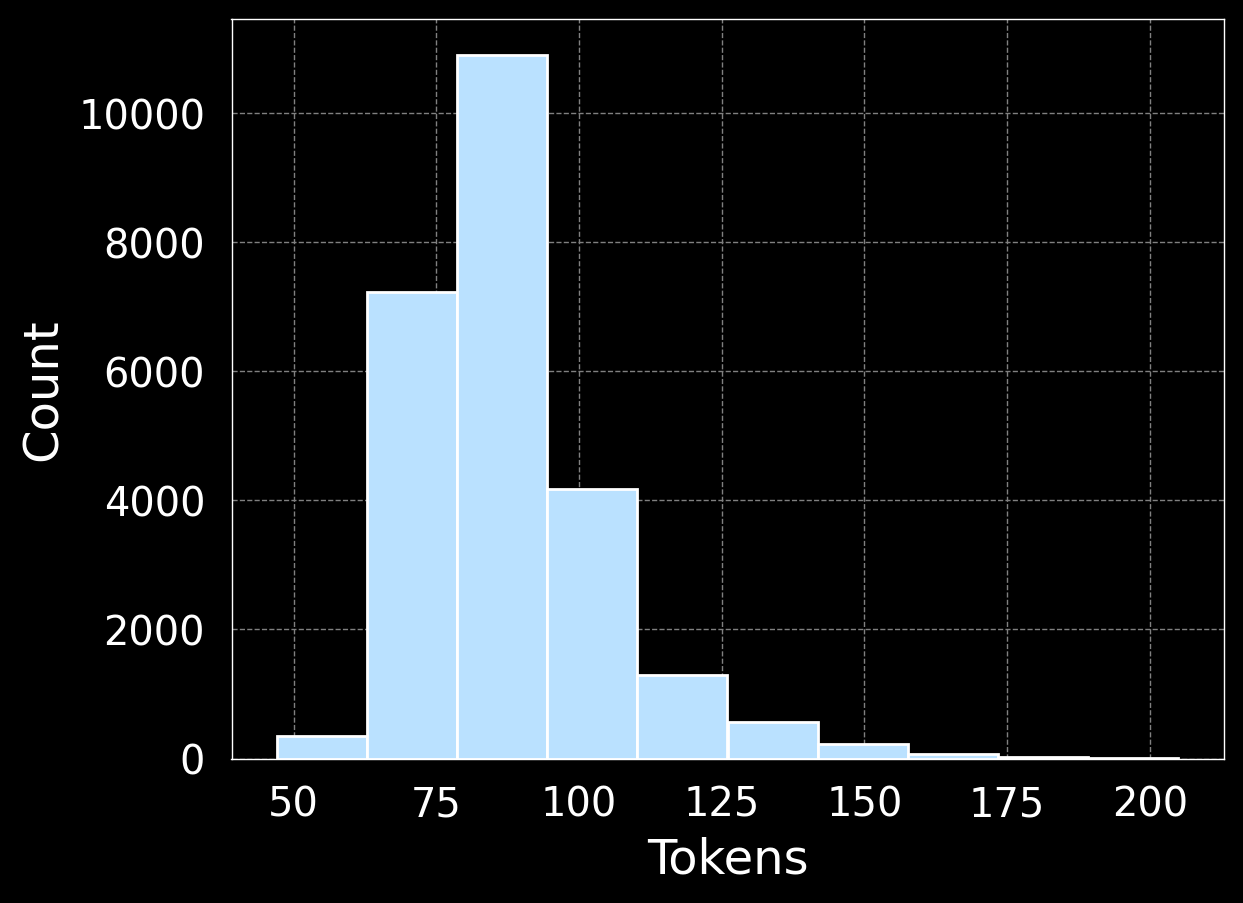

In [ ]:
from tqdm import tqdm

token_counts = []
for example in tqdm(dataset["train"]):
    token_counts.append(
        len(
            tokenizer(
                format_example(example),
                add_special_tokens=True,
                return_attention_mask=False,
            )["input_ids"]
        )
    )

plt.hist(token_counts)
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show();


In [ ]:
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
model.config

LlamaConfig {
  "_name_or_path": "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": 32000,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 32008
}

In [ ]:
model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32008, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

In [ ]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config = LoraConfig(
    r=128,
    lora_alpha=128,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)

model.print_trainable_parameters()

trainable params: 100,925,440 || all params: 1,201,006,592 || trainable%: 8.403404333687455


In [ ]:
response_template = "\n### Prediction:"
response_template_ids = tokenizer.encode(response_template, add_special_tokens=False)[
    2:
]
collator = DataCollatorForCompletionOnlyLM(response_template_ids, tokenizer=tokenizer)

examples = [format_example(dataset["train"][0])]
encodings = [tokenizer(e) for e in examples]

dataloader = DataLoader(encodings, collate_fn=collator, batch_size=1)

In [ ]:
batch = next(iter(dataloader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
batch["labels"]

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,    13, 16009, 29901, 11314,   406,   398,
            13, 18616,  2073, 29901,  6374,     2]])

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir="experiments",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim="adamw_torch",
    evaluation_strategy="steps",
    eval_steps=0.2,
    logging_steps=10,
    learning_rate=1e-4,
    fp16=True,  # or bf16=True,
    save_strategy="epoch",
    max_grad_norm=1.0,
    warmup_ratio=0.1,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    save_safetensors=True,
    seed=SEED,
)

In [ ]:
def format_prompts(example):
    output_texts = []
    for i in range(len(example["title"])):
        text = inspect.cleandoc(
            f"""
### Title:
{example["title"][i]}
### Text:
{example["text"][i]}
### Prediction:
subject: {example["subject"][i]}
sentiment: {example["sentiment"][i]}
"""
        )
        output_texts.append(text)
    return output_texts

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    tokenizer=tokenizer,
    max_seq_length=1024,
    formatting_func=format_prompts,
    data_collator=collator,
)

Map:   0%|          | 0/24829 [00:00<?, ? examples/s]

Map:   0%|          | 0/4966 [00:00<?, ? examples/s]

In [ ]:
trainer.train()


Step,Training Loss,Validation Loss
311,0.144600,0.138697
622,0.103600,0.104869
933,0.093600,0.092284
1244,0.092100,0.084191


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:160: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=1552, training_loss=0.11541696326787938, metrics={'train_runtime': 2353.4646, 'train_samples_per_second': 10.55, 'train_steps_per_second': 0.659, 'total_flos': 1.7841682646581248e+16, 'train_loss': 0.11541696326787938, 'epoch': 1.0})

In [ ]:
trainer.model.save_pretrained("sentiment_analysis_cryptonews_model")
tokenizer.save_pretrained("sentiment_analysis_cryptonews_model")

('sentiment_analysis_cryptonews_model/tokenizer_config.json',
 'sentiment_analysis_cryptonews_model/special_tokens_map.json',
 'sentiment_analysis_cryptonews_model/tokenizer.model',
 'sentiment_analysis_cryptonews_model/added_tokens.json',
 'sentiment_analysis_cryptonews_model/tokenizer.json')

In [ ]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

tokenizer = AutoTokenizer.from_pretrained(
    "sentiment_analysis_cryptonews_model", trust_remote_code=True, add_eos_token=True, use_fast=True
)

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

base_model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)

model = PeftModel.from_pretrained(base_model, "sentiment_analysis_cryptonews_model")
model = model.merge_and_unload()


tokenizer.pad_token, tokenizer.pad_token_id, tokenizer.padding_side

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('<pad>', 32000, 'right')

In [ ]:
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
from transformers import pipeline

pipe = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=16,
    return_full_text=False,
)

In [ ]:
def format_for_prediction(example):
    return inspect.cleandoc(
        f"""
### Title:
{example["title"]}
### Text:
{example["text"]}
### Prediction:
"""
    )

In [ ]:
from transformers import logging

logging.set_verbosity(logging.CRITICAL)

In [ ]:
for i in range(10):
    example = dataset["test"][i]
    print(f"Example {i + 1}\n")
    text = inspect.cleandoc(
        f"""
        Title: {example["title"]}
        Text: {example["text"]}
        Subject: {example["subject"]}
        Sentiment: {example["sentiment"]}
    """
    )
    print(text)
    print("\nPrediction:")
    outputs = pipe(format_for_prediction(example))
    print(outputs[0]["generated_text"])
    print()

Example 1

Title: Binance Research Report Reveals 110% Surge in Crypto Market Cap YTD
Text: Positive shift in stablecoin supply, NFT trade volume resurgence, and increased fees signal crypto market maturation.
Subject: nft
Sentiment: positive

Prediction:

subject: nft
sentiment: positive

Example 2

Title: Bitcoin Price and Ethereum Prediction: BTC Revisits $30,000 \x93 Can Both Cryptocurrencies Bounce Back?
Text: Bitcoin and Ethereum are two major cryptocurrencies that have gained substantial popularity since the beginning of this year. Ethereum (ETH), the second-most popular cryptocurrency, has recently crossed the $2,000 milestone for the first time since May last year.
Subject: altcoin
Sentiment: positive

Prediction:

subject: altcoin
sentiment: positive

Example 3

Title: Ethereum's Last Test Before the Merge 'Quite Good' Despite 'Confusion'
Text: Ethereum's final testnet merge before the blockchain transitions to proof-of-stake (PoS) has ostensibly been successful.
Subject: eth

In [ ]:
import re

from tqdm import tqdm

rows = []

for i in tqdm(range(len(dataset["test"]))):
    example = dataset["test"][i]
    outputs = pipe(format_for_prediction(example))
    text = outputs[0]["generated_text"]
    parts = re.split(r"[:\n]", text.strip())
    subject, sentiment = parts[1].strip(), parts[3].strip()

    rows.append(
        {
            "title": example["title"],
            "text": example["text"],
            "true_subject": example["subject"],
            "true_sentiment": example["sentiment"],
            "pred_subject": subject,
            "pred_sentiment": sentiment,
        }
    )

  0%|          | 0/1242 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1123: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1242/1242 [08:05<00:00,  2.56it/s]


In [ ]:
predictions_df = pd.DataFrame(rows)
predictions_df.head()

,title,text,true_subject,true_sentiment,pred_subject,pred_sentiment
0,Binance Research Report Reveals 110% Surge in ...,"Positive shift in stablecoin supply, NFT trade...",nft,positive,nft,positive
1,Bitcoin Price and Ethereum Prediction: BTC Rev...,Bitcoin and Ethereum are two major cryptocurre...,altcoin,positive,altcoin,positive
2,Ethereum's Last Test Before the Merge 'Quite G...,Ethereum's final testnet merge before the bloc...,ethereum,positive,ethereum,positive
3,Coinbase CEO Calls for Regulation of Centraliz...,The demise of FTX has set back crypto by years...,altcoin,positive,altcoin,positive
4,BNB price rallies on news of DOJ-Binance settl...,The BNB token defied today’s wider market down...,altcoin,positive,altcoin,positive


In [ ]:
(predictions_df["true_subject"] == predictions_df["pred_subject"]).sum() / len(
    predictions_df
)

0.785024154589372

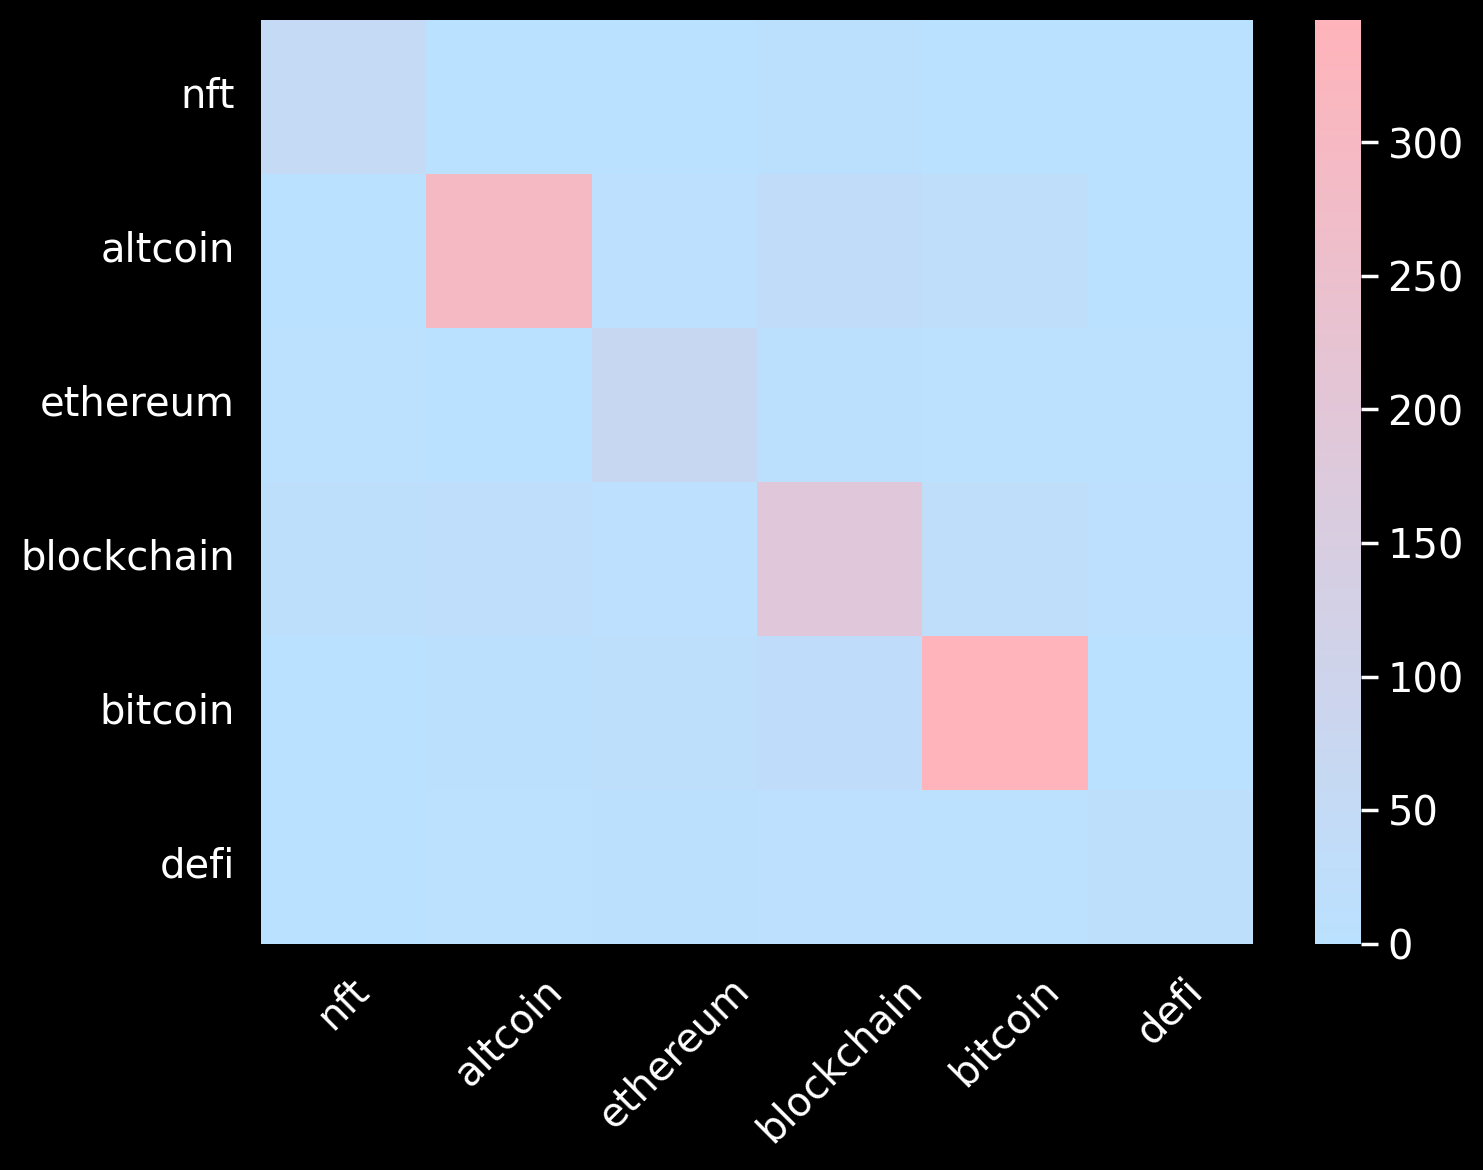

In [ ]:
labels = predictions_df["true_subject"].unique().tolist()
cf_matrix = confusion_matrix(
    predictions_df["true_subject"], predictions_df["pred_subject"], labels=labels
)
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    cmap=cmap,
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);

In [ ]:
predictions_df[predictions_df["true_subject"] != predictions_df["pred_subject"]].head(
    n=10
)[["title", "text", "true_subject", "pred_subject"]]

,title,text,true_subject,pred_subject
5,Bitcoin Price Prediction as BTC Breaks Through...,"Bitcoin, the world's largest cryptocurrency by...",altcoin,bitcoin
6,Blur introduces NFT perpetual lending protocol,Borrowing positions automatically roll their e...,blockchain,nft
12,Ethereum ETF Incoming? Odds of ETH ETFs Skyroc...,There are now more live Ethereum futures ETF a...,bitcoin,ethereum
15,OPNX Offers CoinFLEX Creditors 25% Equity and ...,"Mark Lamb, a fellow CoinFLEX stakeholder and f...",altcoin,blockchain
27,"India Pushes For A Clear G20 Crypto Strategy, ...",India has backed calls for a properly structur...,blockchain,bitcoin
28,Game developers expect to work on Web3 games i...,A new survey showed that developers believe th...,nft,blockchain
37,Fundraising Leaders North Americans are 'Most ...,The Americans are the most likely to write the...,bitcoin,blockchain
45,AI optimizing crypto exchange functions - Bitg...,Artificial intelligence tools are providing so...,bitcoin,blockchain
47,"Aave devs propose freezing Fantom integration,...",The Fantom market on Aave V3 adds just $30 eac...,blockchain,defi
55,Bitcoin Price and Ethereum Prediction: A Packe...,"Bitcoin (BTC), the world's largest cryptocurre...",altcoin,bitcoin


In [ ]:
(predictions_df["true_sentiment"] == predictions_df["pred_sentiment"]).sum() / len(
    predictions_df
)

0.9033816425120773

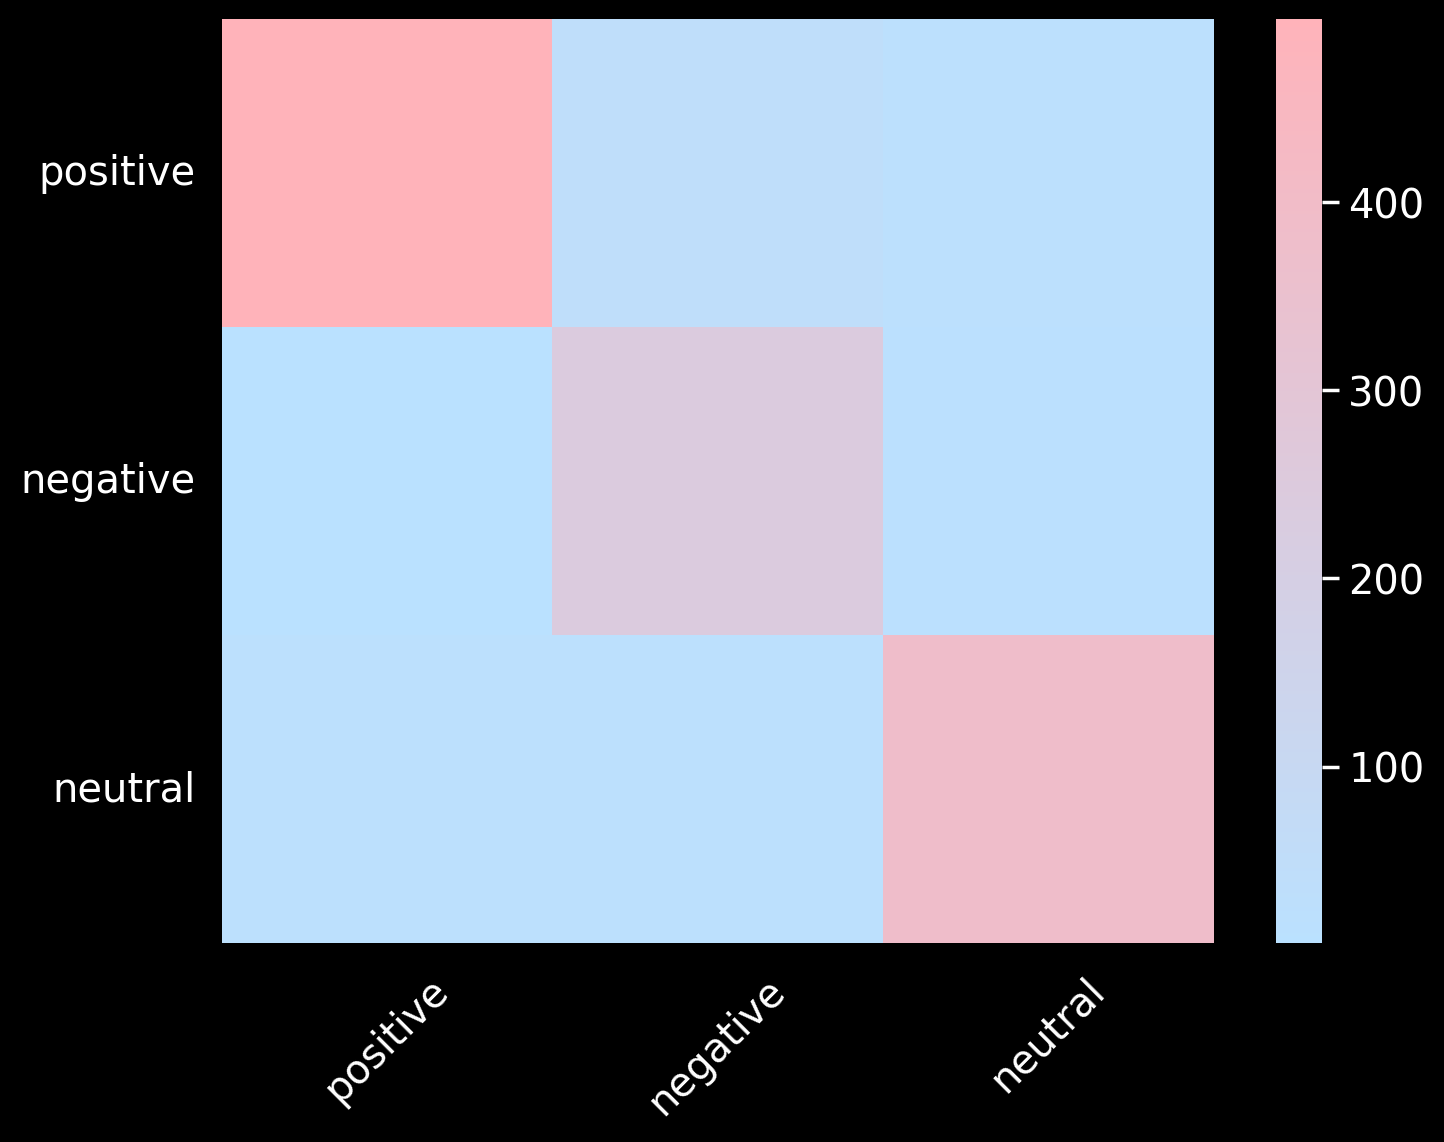

In [ ]:
labels = predictions_df["true_sentiment"].unique().tolist()
cf_matrix = confusion_matrix(
    predictions_df["true_sentiment"], predictions_df["pred_sentiment"], labels=labels
)
_, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    cmap=cmap,
    ax=ax,
)
ax.set_yticklabels(labels, rotation=0)
ax.set_xticklabels(labels, rotation=45);

In [ ]:
predictions_df[
    predictions_df["true_sentiment"] != predictions_df["pred_sentiment"]
].head(n=10)[["title", "text", "true_sentiment", "pred_sentiment"]]

,title,text,true_sentiment,pred_sentiment
6,Blur introduces NFT perpetual lending protocol,Borrowing positions automatically roll their e...,negative,neutral
8,What happened? Terra debacle exposes flaws pla...,The downfall of Terra calls into question the ...,neutral,negative
41,Volatile interest rates may be a thing of the ...,This crypto platform is bringing fixed interes...,positive,neutral
43,Leading incubator drives continuous efforts an...,Blockchain gaming transitions the power of dev...,negative,positive
44,Bitcoin's real energy use questioned as Ethere...,A founding member of Ethereum has claimed that...,positive,neutral
53,"What are buy and sell walls in crypto, and how...",Whales can manipulate buy and sell orders beca...,negative,neutral
70,Transit Swap ‘hacker’ returns lion’s share of ...,Majority of the DeFi tokens in Top-100 traded ...,neutral,positive
72,Bad News is Good News: Bitcoin Plays With USD ...,Bitcoin reached its highest price in nearly 7 ...,positive,neutral
76,Bitcoin price levels to watch as Terra buys 2....,Things are looking precarious for Bitcoin this...,positive,negative
83,Crypto Prices Crash as FTX Crypto Exchange Col...,The price of almost all major cryptocurrencies...,positive,negative
